In [1]:
# Import python modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

/home/csi20local/snap/jupyter/common/lib/python3.7/site-packages/joblib/_multiprocessing_helpers.py:45: UserWarning: [Errno 13] Permission denied.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


In [2]:
# Full 30 Case List

FullCaseList = ['01', '02', '05', '06', '07', '08', '09', '10', '12', '14', '15', '16',
                '17', '18', '19', '20', '21', '23', '24', '25', '26', '27', '28', '29',
                '30', '32']
FullCaseList = ['CT-CRT-' + case for case in FullCaseList]
AddCases = ['EBR-01', 'EBR-02', 'Normal-1', 'Normal-3']
FullCaseList = FullCaseList + AddCases

# FIMH 10 Case List

FIMHCaseList = ['01', '02', '05', '06', '07', '08', '09', '12', '15', '16']
FIMHCaseList = ['CT-CRT-' + case for case in FIMHCaseList]

# Sklearn method to do 10-fold cv split into random train, test cases

kf = KFold(n_splits=10, shuffle=True)

# Create char array of 30 Case list

Cases_charar = np.chararray((30,), itemsize=9)
Cases_charar[:] = FullCaseList

In [3]:
# This cell generates a list of all errors types

import os

path = "/home/csi20local/Data/RG_CT_Cases/CT-CRT-05/"

path_contents = os.listdir(path)

start_letter = "MT-HiRes"
end_letter = ".csv"
MT_HiRes_files = [x for x in path_contents if x.startswith(start_letter) and x.endswith(end_letter)]

all_errors = []

for i in MT_HiRes_files:
    error = i.replace('MT-HiRes-', '')
    
    all_errors.append(error)

for i in range(0, len(all_errors)):
    
    if 'AbsoluteError' in all_errors[i]:
        all_errors[i] = all_errors[i].replace('-AbsoluteError.csv', '')
    
    if 'PercentageErrors' in all_errors[i]:
        all_errors[i] = all_errors[i].replace('-PercentageErrors.csv', '')
        
    if 'Results' in all_errors[i]:
        all_errors[i] = all_errors[i].replace('-Results.csv', '')
        
    if 'Normal' in all_errors[i]:
        all_errors[i] = 'ASD'
        
    if 'Hausdorff' in all_errors[i]:
        all_errors[i] = 'DHD'

In [4]:
"""
Calculates unified z-score of all (SW,BE) combo's across a provided list of cases for training. 

INPUT: List of cases. Error type.

OUTPUT: Mean, std deviation, DataFrame of medians (across cases) of each hyperparameter combination, DataFrame of
        z score of each hyperparameter combination across cases
"""

def S_unified(case_list, Error):
    
    # Dict to convert error nickname to csv filename
    error_dict = {'ASD': 'Normal-Distance-Results', 'DHD': 'Hausdorff-Distance-Results', 'Dice': 'Dice-Results',
                 'LAA': 'LAA-AbsoluteError', 'LSPV': 'LSPV-AbsoluteError', 'LIPV': 'LIPV-AbsoluteError',
                 'RSPV': 'RSPV-AbsoluteError', 'RIPV': 'RIPV-AbsoluteError',
                 'LAA-LS': 'LAA-LS-PercentageErrors', 'LAA-LI': 'LAA-LI-PercentageErrors', 
                 'LAA-RS': 'LAA-RS-PercentageErrors', 'LAA-RI': 'LAA-RS-PercentageErrors',
                 'LS-LI': 'LS-LI-PercentageErrors', 'LS-RS': 'LS-RS-PercentageErrors', 
                 'LS-RI': 'LS-RI-PercentageErrors', 'LI-RS': 'LI-RS-PercentageErrors', 
                 'LI-RI': 'LI-RI-PercentageErrors', 'RS-RI': 'RS-RI-PercentageErrors',
                 'MV': 'MV-AbsoluteError'}
    
    Error = error_dict[Error]
    
    # Omit cases which lack LAA in the LAA error calculation
    if 'LAA' in Error:
            case_list = list(case_list)
            if 'CT-CRT-09' in case_list:
                case_list.remove('CT-CRT-09')
            
            case_list = tuple(case_list)
            
    # Omit cases which lack LI in the LI error calculation
    if 'LI' in Error:
            case_list = list(case_list)
            if 'CT-CRT-18' in case_list:
                case_list.remove('CT-CRT-18')
            
            if 'CT-CRT-23' in case_list:
                case_list.remove('CT-CRT-23')
                
            if 'Normal-3' in case_list:    
                case_list.remove('Normal-3')
            
            case_list = tuple(case_list)
    
    # Create array to hold errors across cases for each (SW,BE) participant
    cases_array = np.zeros(shape=(63,len(case_list)))
    
    # Create list of cases with 20 time frames
    TDownsampledCases = ['21', '23', '24', '25', '26', '27', '28', '29', '30', '32']
    TDownsampledCases = ['CT-CRT-' + case for case in TDownsampledCases]
    TDownsampledCases_add = ['EBR-01', 'EBR-02']
    TDownsampledCases = TDownsampledCases + TDownsampledCases_add
        
    for Case in case_list:
        
        if Case in TDownsampledCases:
            df_read = pd.read_csv(f'/home/csi20local/Data/RG_CT_Cases/{Case}/MT-HiRes-TDownsampled-{Error}.csv', 
                        sep = ' ', index_col = 0)
            df_array = df_read.to_numpy() 
            flattened_array = np.reshape(df_array, 63) # flatten array to 1D array with 63 elements
    
            cases_array[:, case_list.index(Case)] = flattened_array # assign flattened array to corresponding case col.
    
        else:
            df_read = pd.read_csv(f'/home/csi20local/Data/RG_CT_Cases/{Case}/MT-HiRes-{Error}.csv', 
                        sep = ' ', index_col = 0)
            df_array = df_read.to_numpy()
            flattened_array = np.reshape(df_array, 63)
                
            cases_array[:, case_list.index(Case)] = flattened_array
                
    # Create array for medians of errors for each (SE, BE) combo across cases
    medians = np.zeros(63)

    for i in range(0,cases_array.shape[0]):
        # Take median across case columns for each (SW,BE) participant and assign to medians array
        medians[i] = np.median(cases_array[i, :])
            
    # Find mean and std dev of medians across 63 (SW, BE) combinations
    mean = np.mean(medians)
    std = np.std(medians)
        
    BE_rename = {0: 4e-6, 1: 1e-6, 2: 4e-7, 3: 1e-7, 4: 4e-8, 5: 1e-8, 6: 4e-9, 7: 1e-9, 8: 4e-10}
    SW_rename = {0: '9e-2', 1: '3e-2', 2: '9e-3', 3: '3e-3', 4: '9e-4', 5: '3e-4', 6: '0.0'}
  
    # Create Dataframe of Median error for each (SW, BE) combination 
    df_medians = np.reshape(medians, (9,7))
    df_medians = pd.DataFrame(df_medians)
    df_medians = df_medians.rename(index = BE_rename, columns=SW_rename)
    
    # Create Dataframe of Z scores for each (SE, BE) combination
    df_zscore = (df_medians-mean)/std
    df_zscore = df_zscore.rename(index = BE_rename, columns=SW_rename)
    
    if Error == "Dice-Results":
        
        # Correct mean and medians in the case of minimising DSC means improving segmentation
        mean = 1 - mean
        df_medians = 1 - df_medians
        
        df_zscore = (df_medians-mean)/std
#         df_zscore = 1 - df_zscore # Old code
    
    return mean, std, df_medians, df_zscore

In [ ]:
# FOR ALL 19 ERRORS

# Doing 10-fold cross validation

# Split 30 Case list into training and test sets using 10-fold cv
kf_split = list(kf.split(FullCaseList))

# Create arrays that contain indicies of training and testing cases for each of 10 folds

train_cases_ind = np.zeros((10, 27))
test_cases_ind = np.zeros((10, 3))
train_cases_ind = train_cases_ind.astype(int)
test_cases_ind = test_cases_ind.astype(int)

for i in range(0, train_cases_ind.shape[0]):
    
    train_cases_ind[i, :] = kf_split[i][0]
    test_cases_ind[i, :] = kf_split[i][1]
    
# Create lists that contain training and testing cases for each fold.
# Length of lists is 10 as there are 10 folds.

# The i'th element of each list is a list of training/testing case names in i'th fold

train_cases_folds = [] 
test_cases_folds = []

for i in range(0, train_cases_ind.shape[0]):
    train_cases_folds.append([FullCaseList[i] for i in train_cases_ind[i]])
    test_cases_folds.append([FullCaseList[i] for i in test_cases_ind[i]])

# Create array to sum Z-scores from each fold
sum_folds_ar = np.zeros((9,7))

# For every set of training cases in each fold:
for train_cases in train_cases_folds:
    
    # Create df of Z-scores using first error
    df = S_unified(train_cases, all_errors[0])[-1]

    # Sum the remaining errors' Z-scores to df
    for i in range(1, len(all_errors)):
        df = df + S_unified(train_cases, all_errors[i])[-1]
    
    # Mean across all 19 types of error
    df = df / 19
    
    # Add Z-score Dataframe from all 19 errors to sum_folds_ar
    print("Adding df to sum_folds_ar")
    sum_folds_ar = sum_folds_ar + df.to_numpy()

df_sum = pd.DataFrame(sum_folds_ar)

BE_rename = {0: 4e-6, 1: 1e-6, 2: 4e-7, 3: 1e-7, 4: 4e-8, 5: 1e-8, 6: 4e-9, 7: 1e-9, 8: 4e-10}
SW_rename = {0: '9e-2', 1: '3e-2', 2: '9e-3', 3: '3e-3', 4: '9e-4', 5: '3e-4', 6: '0.0'}
    
df_sum = df_sum.rename(index = BE_rename, columns=SW_rename)
df_all_errors = df_sum / 10

In [6]:
def tenfold_cv_19_errors():
    
    # Split 30 Case list into training and test sets using 10-fold cv
    kf_split = list(kf.split(FullCaseList))
    
    # Create arrays that contain indicies of training and testing cases for each of 10 folds
    train_cases_ind = np.zeros((10, 27))
    test_cases_ind = np.zeros((10, 3))
    train_cases_ind = train_cases_ind.astype(int)
    test_cases_ind = test_cases_ind.astype(int)
    
    for i in range(0, train_cases_ind.shape[0]):
        train_cases_ind[i, :] = kf_split[i][0]
        test_cases_ind[i, :] = kf_split[i][1]
    
    # Create lists that contain training and testing cases for each fold.
    # Length of lists is 10 as there are 10 folds.

    # The i'th element of each list is a list of training/testing case names in i'th fold

    train_cases_folds = [] 
    test_cases_folds = []

    for i in range(0, train_cases_ind.shape[0]):
        train_cases_folds.append([FullCaseList[i] for i in train_cases_ind[i]])
        test_cases_folds.append([FullCaseList[i] for i in test_cases_ind[i]])

    # Create array to sum Z-scores from each fold
    sum_folds_ar = np.zeros((9,7))

    # For every set of training cases in each fold:
    for train_cases in train_cases_folds:

        # Create df of Z-scores using first error
        df = S_unified(train_cases, all_errors[0])[-1]

        # Sum the remaining errors' Z-scores to df
        for i in range(1, len(all_errors)):
            df = df + S_unified(train_cases, all_errors[i])[-1]

        # Mean across all 19 types of error
        df = df / 19

        # Add Z-score Dataframe from all 19 errors to sum_folds_ar
        print("Adding df to sum_folds_ar")
        sum_folds_ar = sum_folds_ar + df.to_numpy()

    df_sum = pd.DataFrame(sum_folds_ar)

    BE_rename = {0: 4e-6, 1: 1e-6, 2: 4e-7, 3: 1e-7, 4: 4e-8, 5: 1e-8, 6: 4e-9, 7: 1e-9, 8: 4e-10}
    SW_rename = {0: '9e-2', 1: '3e-2', 2: '9e-3', 3: '3e-3', 4: '9e-4', 5: '3e-4', 6: '0.0'}

    df_sum = df_sum.rename(index = BE_rename, columns=SW_rename)
    df_all_errors = df_sum / 10
    

    return df_all_errors

In [9]:
df = tenfold_cv_19_errors()

Adding df to sum_folds_ar
Adding df to sum_folds_ar
Adding df to sum_folds_ar
Adding df to sum_folds_ar
Adding df to sum_folds_ar
Adding df to sum_folds_ar
Adding df to sum_folds_ar
Adding df to sum_folds_ar
Adding df to sum_folds_ar
Adding df to sum_folds_ar


In [10]:
df

,9e-2,3e-2,9e-3,3e-3,9e-4,3e-4,0.0
4.000000e-06,0.210460,-0.027598,-0.159500,0.066781,-0.200063,0.040800,-0.272239
1.000000e-06,-0.322875,0.401644,0.190859,0.014692,-0.023604,-0.079836,0.252126
4.000000e-07,-0.272854,0.152266,0.147361,0.007243,-0.243434,-0.181403,-0.125163
1.000000e-07,0.123815,0.252136,-0.125681,0.263697,0.067594,0.575994,-0.362853
4.000000e-08,0.085315,-0.156568,0.200055,0.225529,-0.226681,-0.185772,-0.105664
1.000000e-08,0.150509,0.296847,0.047032,0.167944,-0.336589,-0.262048,-0.240605
4.000000e-09,-0.041364,0.305196,0.215690,-0.037198,-0.175650,0.212415,-0.421617
1.000000e-09,0.049050,0.242987,0.012009,-0.166664,0.053784,-0.159262,-0.217602
4.000000e-10,-0.319796,-0.059788,0.361974,0.013772,0.244281,0.161758,-0.303642


In [22]:
# Figure visualising different goes with CV

ar = np.zeros((1,10))
list_df = []

for i in range(0, 10):
    
    print(i)
    df_loop = tenfold_cv_19_errors()
    list_df.append(df_loop)
    
#     ar[0][i] = tenfold_cv_19_errors()

0
Adding df to sum_folds_ar
Adding df to sum_folds_ar
Adding df to sum_folds_ar
Adding df to sum_folds_ar
Adding df to sum_folds_ar
Adding df to sum_folds_ar
Adding df to sum_folds_ar
Adding df to sum_folds_ar
Adding df to sum_folds_ar
Adding df to sum_folds_ar
1
Adding df to sum_folds_ar
Adding df to sum_folds_ar
Adding df to sum_folds_ar
Adding df to sum_folds_ar
Adding df to sum_folds_ar
Adding df to sum_folds_ar
Adding df to sum_folds_ar
Adding df to sum_folds_ar
Adding df to sum_folds_ar
Adding df to sum_folds_ar
2
Adding df to sum_folds_ar
Adding df to sum_folds_ar
Adding df to sum_folds_ar
Adding df to sum_folds_ar
Adding df to sum_folds_ar
Adding df to sum_folds_ar
Adding df to sum_folds_ar
Adding df to sum_folds_ar
Adding df to sum_folds_ar
Adding df to sum_folds_ar
3
Adding df to sum_folds_ar
Adding df to sum_folds_ar
Adding df to sum_folds_ar
Adding df to sum_folds_ar
Adding df to sum_folds_ar
Adding df to sum_folds_ar
Adding df to sum_folds_ar
Adding df to sum_folds_ar
Addi

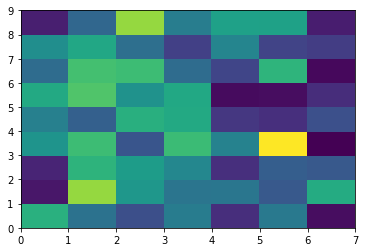

In [23]:
plt.pcolor(list_df[0])

Text(0.5, 0.98, 'Wag1')

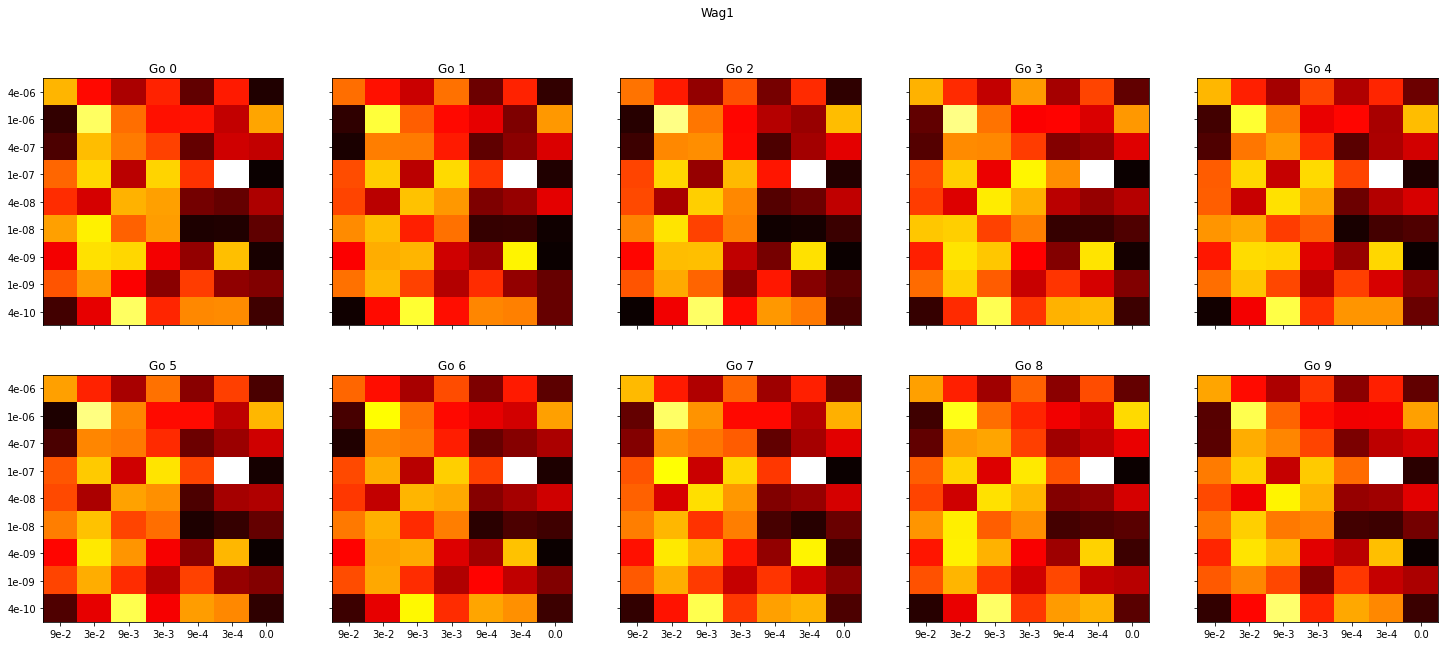

In [56]:
fig, axs = plt.subplots(2, 5, sharex=True, sharey=True, figsize=(25,10))

for i in range(0, 5):
    ax = axs[0, i]
    c = ax.pcolor(list_df[i], cmap='hot')
    ax.set_title(f"Go {i}")
    
    ax.set_yticks(np.arange(0.5, len(list_df[0].index), 1))
    ax.set_xticks(np.arange(0.5, len(list_df[0].columns), 1))
    ax.set_yticklabels(list_df[0].index)
    ax.set_xticklabels(list_df[0].columns)
    
for i in range(0, 5):
    ax = axs[1, i]
    j = i+5
    c = ax.pcolor(list_df[j], cmap='hot')
    ax.invert_yaxis()
    ax.set_title(f"Go {j}")

# fig.colorbar(c, ax=ax)
fig.suptitle("Wag1")